In [1]:
import os
import sys
import shutil
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from cifar10_data import CIFAR10RandomLabels
from cifar100_data import CIFAR100RandomLabels
from torch.autograd import Variable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
class MyAlexNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(MyAlexNetFeatureExtractor, self).__init__()
        self.Conv2d_0 = model.features[0]
        self.ReLU_1 = model.features[1]
        self.MaxPool2d_2 = model.features[2]
        self.Conv2d_3 = model.features[3]
        self.ReLU_4 = model.features[4]
        self.MaxPool2d_5 = model.features[5]
        self.Conv2d_6 = model.features[6]
        self.ReLU_7 = model.features[7]
        self.Conv2d_8 = model.features[8]
        self.ReLU_9 = model.features[9]
        self.Conv2d_10 = model.features[10]
        self.ReLU_11 = model.features[11]
        self.MaxPool2d_12 = model.features[12]
        self.linear = model.classifier
    def forward(self, x):
        out0 = self.Conv2d_0(x)
        out1 = self.ReLU_1(out0)
        out2 = self.MaxPool2d_2(out1)
        out3 = self.Conv2d_3(out2)
        out4 = self.ReLU_4(out3)
        out5 = self.MaxPool2d_5(out4)
        out6 = self.Conv2d_6(out5)
        out7 = self.ReLU_7(out6)
        out8 = self.Conv2d_8(out7)
        out9 = self.ReLU_9(out8)
        out10 = self.Conv2d_10(out9)
        out11 = self.ReLU_11(out10)
        out12 = self.MaxPool2d_12(out11)
        out12 = out12.view(out12.size(0), -1)
        out13 = self.linear(out12)
        # return reshaped tensor to calculate the spectral norm
        f0 = out0.view(out0.size(0),-1).data
        f2 = out2.view(out2.size(0),-1).data
        f3 = out3.view(out3.size(0),-1).data
        f5 = out5.view(out5.size(0),-1).data
        f6 = out6.view(out6.size(0),-1).data
        f7 = out7.view(out7.size(0),-1).data
        f8 = out8.view(out8.size(0),-1).data
        f9 = out9.view(out9.size(0),-1).data
        f10 = out10.view(out10.size(0),-1).data
        return f0,f2,f3,f5,f6,f7,f8,f9,f10

In [4]:
def cal_margin(trainloader, model):
#     model = AlexNet(num_classes)
#     model_state = torch.load('model_'+str(iterations[i]), map_location=lambda storage, loc: storage)
#     model.load_state_dict(model_state)
    margin = []
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inp = inputs
        tar = targets
        b = model(Variable(inputs))
        c = b.topk(2)[0][:,1].data.numpy()
        bnp = b.data.numpy()
        for j in range(b.shape[0]):
            margin.append(bnp[j,tar[j]]-c[j])
    margin = np.array(margin)
    return margin

In [6]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader_random = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=1.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [163]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloader = data.DataLoader(
    CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=0.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)

Files already downloaded and verified


In [22]:
model = AlexNet(10)
model_state = torch.load('model_300_cifar', map_location=lambda storage, loc: storage)
model.load_state_dict(model_state)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=10)
)

In [9]:
model_random = AlexNet(10)
model_random_state = torch.load('model_300_random', map_location=lambda storage, loc: storage)
model_random.load_state_dict(model_random_state)
model_random.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=10)
)

In [23]:
margin = cal_margin(trainloader, model)
margin_random = cal_margin(trainloader_random, model_random)

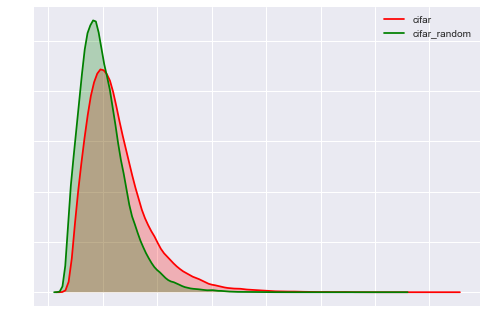

In [113]:
sns.distplot(margin, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('margin.pdf', bbox_inches='tight')
plt.show()

In [5]:
def cal_spectral(trainloader, model):
    FeatureExtractor = MyAlexNetFeatureExtractor(model)
    average = np.zeros(5)
    count = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        count += inputs.shape[0]
        inp = inputs
        inp_flat = inp.view(inp.size(0),-1)
        f0,f2,f3,f5,f6,f7,f8,f9, f10 = FeatureExtractor(Variable(inp))
        average[0]+= sum(torch.norm(f0,2,dim = 1)/torch.norm(inp_flat,2,dim = 1))
        average[1]+= sum(torch.norm(f3,2,dim = 1)/torch.norm(f2,2,dim = 1))
        average[2]+= sum(torch.norm(f6,2,dim = 1)/torch.norm(f5,2,dim = 1))
        average[3]+= sum(torch.norm(f7,2,dim = 1)/torch.norm(f8,2,dim = 1))
        average[4]+= sum(torch.norm(f10,2,dim = 1)/torch.norm(f9,2,dim = 1))
    average = average/float(count)  
    return average

In [6]:
def cal_Lipschitz(A, model):
    ### Input the spectral norms A calculated by cal_spectral
    Lip = 1
    for i in range(A.shape[0]):
        Lip *= A[i]
    Lip *= np.linalg.norm(model.classifier.weight.data.numpy(), ord = 2)
    return Lip

In [7]:
def cal_complexity(A, model):
    ### Input the spectral norms A calculated by cal_spectral
    complexity = cal_Lipschitz(A, model)
    plu = 0
    # 1-norm
    indices = [0,3,6,8,10]
    for i in range(A.shape[0]):
        A1 = torch.norm(model.features[indices[i]].weight.view(-1).data, p = 1)
        plu += (A1/A[i])**(2.0/3)
    lin_spec = np.linalg.norm(model.classifier.weight.data.numpy(), ord = 2)
    lin_1 = torch.norm(model.classifier.weight.view(-1).data, p = 1)
    plu += (lin_1/lin_spec)**(2.0/3)
    plu = plu**(3.0/2)
    complexity = complexity * plu
    return complexity

In [115]:
A_spectral = cal_spectral(trainloader, model)
A_spectral_random = cal_spectral(trainloader_random, model_random)

In [118]:
comp = cal_complexity(A_spectral, model)
comp_random = cal_complexity(A_spectral_random, model_random)

In [119]:
### Normalize
comp = comp/10000.0
comp_random = comp_random/10000.0

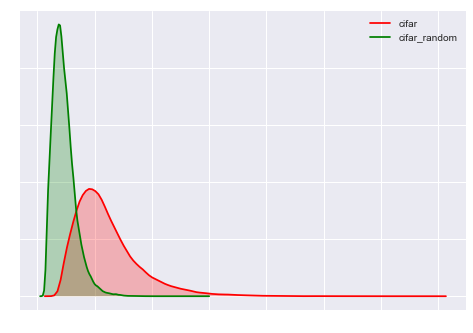

In [120]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin/comp, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar')
sns.distplot(margin_random/comp_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar_random')
plt.savefig('margin_normalized.pdf', bbox_inches='tight')
plt.show()

In [149]:
np.save('norm_margin', margin/comp)
np.save('norm_margin_random',margin_random/comp_random)

## regularization

In [124]:
model_4 = AlexNet(10)
model_4_state = torch.load('model_300_4', map_location=lambda storage, loc: storage)
model_4.load_state_dict(model_4_state)
model_4.eval()
margin_4 = cal_margin(trainloader, model_4)
A_spectral_4 = cal_spectral(trainloader, model_4)
comp_4 = cal_complexity(A_spectral_4, model_4)
norm_margin_4 = margin_4/comp_4
model_5 = AlexNet(10)
model_5_state = torch.load('model_300_5', map_location=lambda storage, loc: storage)
model_5.load_state_dict(model_5_state)
model_5.eval()
margin_5 = cal_margin(trainloader, model_5)
A_spectral_5 = cal_spectral(trainloader, model_5)
comp_5 = cal_complexity(A_spectral_5, model_5)
norm_margin_5 = margin_5/comp_5
model_6 = AlexNet(10)
model_6_state = torch.load('model_300_6', map_location=lambda storage, loc: storage)
model_6.load_state_dict(model_6_state)
model_6.eval()
margin_6 = cal_margin(trainloader, model_6)
A_spectral_6 = cal_spectral(trainloader, model_6)
comp_6 = cal_complexity(A_spectral_6, model_6)
norm_margin_6 = margin_6/comp_6

In [133]:
norm_comp_4 = comp_4/10000.0
norm_comp_5 = comp_5/10000.0
norm_comp_6 = comp_6/10000.0
norm_margin_4 = margin_4/norm_comp_4
norm_margin_5 = margin_5/norm_comp_5
norm_margin_6 = margin_6/norm_comp_6

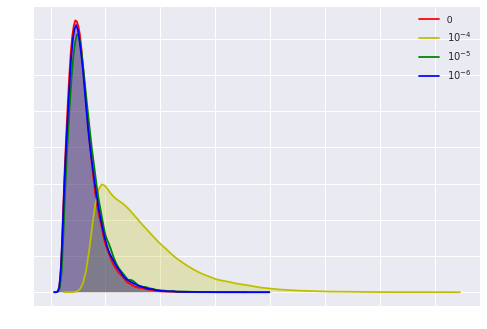

In [136]:
# sns.set_style({'ytick.color': 'w'})
# sns.set_style({'xtick.color': 'w'})
sns.distplot(margin/comp, hist=False, color='r', kde_kws={"shade": True}, label = '0')
sns.distplot(norm_margin_4, hist=False, color='y', kde_kws={"shade": True}, label = '$10^{-4}$')
sns.distplot(norm_margin_5, hist=False, color='g', kde_kws={"shade": True}, label = '$10^{-5}$')
sns.distplot(norm_margin_6, hist=False, color='b', kde_kws={"shade": True}, label = '$10^{-6}$')
plt.savefig('regularization')
plt.show()

In [131]:
norm_margin_4

array([  2.12546685e-04,   2.60278874e-04,   8.51742807e-05, ...,
         1.04754392e-04,   2.32208986e-04,   1.60736206e-04], dtype=float32)

In [129]:
margin/comp

array([ 0.38963965,  0.67875636,  0.87523162, ...,  0.47998914,
        0.63344884,  0.90661985], dtype=float32)

## Cifar100

In [155]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 100
train_batch = 128
test_batch = 100
workers = 4
trainloader_100 = data.DataLoader(
    CIFAR100RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                    num_classes=num_classes, transform = transform_train,
                        corrupt_prob=0.0),
    batch_size=train_batch, shuffle=True, num_workers=workers)
model_100 = AlexNet(100)
model_100_state = torch.load('model_cifar100', map_location=lambda storage, loc: storage)
model_100.load_state_dict(model_100_state)
model_100.eval()

Files already downloaded and verified


AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=100)
)

In [156]:
margin100 = cal_margin(trainloader_100, model_100)


In [157]:
A100 = cal_spectral(trainloader_100, model_100)


NameError: name 'cal_comp' is not defined

In [158]:
comp100 = cal_complexity(A100,model_100)

In [159]:
comp100 = comp100/10000.0

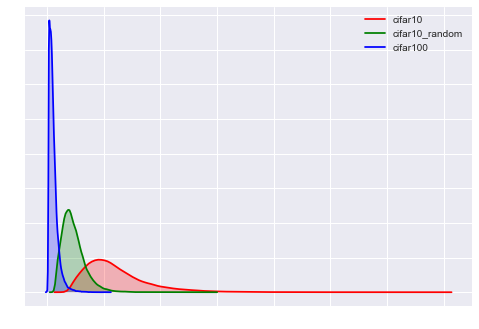

In [162]:
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
sns.distplot(margin/comp, hist=False, color='r', kde_kws={"shade": True}, label = 'cifar10')
sns.distplot(margin_random/comp_random, hist=False, color='g', kde_kws={"shade": True}, label = 'cifar10_random')
sns.distplot(margin100/comp100, hist=False, color='b', kde_kws={"shade": True}, label = 'cifar100')
plt.savefig('margin_normalized_100.pdf', bbox_inches='tight')
plt.show()

In [166]:
for batch_idx, (inputs, targets) in enumerate(trainloader):
    inp = inputs
    inp_flat = inp.view(inp.size(0),-1)
    norm_10 = sum(torch.norm(inp_flat,2,dim = 1))
    break
for batch_idx, (inputs, targets) in enumerate(trainloader_100):
    inp = inputs
    inp_flat = inp.view(inp.size(0),-1)
    norm_100 = sum(torch.norm(inp_flat,2,dim = 1))
    break

In [169]:
norm_10

7179.971641540527

In [151]:
class CIFAR100RandomLabels(datasets.CIFAR100):
  """CIFAR10 dataset, with support for randomly corrupt labels.

  Params
  ------
  corrupt_prob: float
    Default 0.0. The probability of a label being replaced with
    random label.
  num_classes: int
    Default 10. The number of classes in the dataset.
  """
  def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
    super(CIFAR100RandomLabels, self).__init__(**kwargs)
    self.n_classes = num_classes
    if corrupt_prob > 0:
      self.corrupt_labels(corrupt_prob)

  def corrupt_labels(self, corrupt_prob):
    labels = np.array(self.train_labels if self.train else self.test_labels)
    np.random.seed(12345)
    mask = np.random.rand(len(labels)) <= corrupt_prob
    rnd_labels = np.random.choice(self.n_classes, mask.sum())
    labels[mask] = rnd_labels
    # we need to explicitly cast the labels from npy.int64 to
    # builtin int type, otherwise pytorch will fail...
    labels = [int(x) for x in labels]

    if self.train:
      self.train_labels = labels
    else:
      self.test_labels = labels

## compare corrupt

In [9]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
transform_train = transforms.Compose([
transforms.ToTensor(),
normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])
dataloader = datasets.CIFAR10
num_classes = 10
train_batch = 128
test_batch = 100
workers = 4
trainloaders = []
corrupt = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
models = []
for i in range(6):
    trainloaders.append(data.DataLoader(
        CIFAR10RandomLabels(root='/Users/hanxintian/Downloads/1005project/inference_project/cifar10Alexnet/data', train=True, download=True,
                        num_classes=num_classes, transform = transform_train,
                            corrupt_prob=corrupt[i]),
        batch_size=train_batch, shuffle=True, num_workers=workers))
    model0 = AlexNet(10)
    model0_state = torch.load('model_'+str(int(corrupt[i]*10)), map_location=lambda storage, loc: storage)
    model0.load_state_dict(model0_state)
    model0.eval()
    models.append(model0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
margins = []
for i in range(6):
    margins.append(cal_margin(trainloaders[i], models[i]))

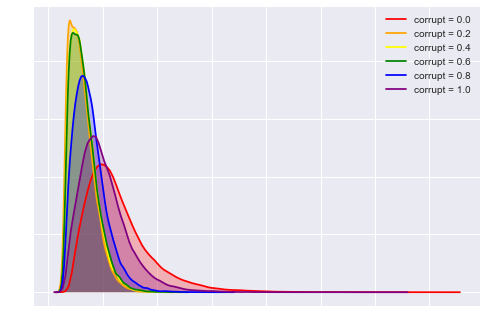

In [18]:
colors = ['red','orange','yellow', 'green','blue','purple']
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
for i in range(6):
    sns.distplot(margins[i], hist=False, color=colors[i], kde_kws={"shade": True}, label = 'corrupt = '+str(corrupt[i]))
plt.savefig('margin_corrupt')
plt.show()

In [14]:
comps = []
for i in range(6):
    A = cal_spectral(trainloaders[i], models[i])
    comp = cal_complexity(A, models[i])
    comps.append(comp)


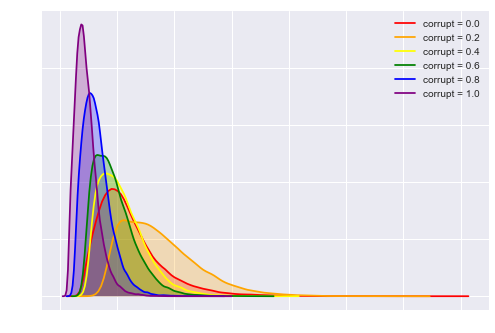

In [17]:
colors = ['red','orange','yellow', 'green','blue','purple']
sns.set_style({'ytick.color': 'w'})
sns.set_style({'xtick.color': 'w'})
for i in range(6):
    sns.distplot(margins[i]/comps[i], hist=False, color=colors[i], kde_kws={"shade": True}, label = 'corrupt = '+str(corrupt[i]))
plt.savefig('norm_margin_corrupt')
plt.show()

In [8]:
"""
cifar-10 dataset, with support for random labels
"""
import numpy as np

import torch
import torchvision.datasets as datasets


class CIFAR10RandomLabels(datasets.CIFAR10):
  """CIFAR10 dataset, with support for randomly corrupt labels.

  Params
  ------
  corrupt_prob: float
    Default 0.0. The probability of a label being replaced with
    random label.
  num_classes: int
    Default 10. The number of classes in the dataset.
  """
  def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
    super(CIFAR10RandomLabels, self).__init__(**kwargs)
    self.n_classes = num_classes
    if corrupt_prob > 0:
      self.corrupt_labels(corrupt_prob)

  def corrupt_labels(self, corrupt_prob):
    labels = np.array(self.train_labels if self.train else self.test_labels)
    np.random.seed(12345)
    mask = np.random.rand(len(labels)) <= corrupt_prob
    rnd_labels = np.random.choice(self.n_classes, mask.sum())
    labels[mask] = rnd_labels
    # we need to explicitly cast the labels from npy.int64 to
    # builtin int type, otherwise pytorch will fail...
    labels = [int(x) for x in labels]

    if self.train:
      self.train_labels = labels
    else:
      self.test_labels = labels

